In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

## Exploratory Data Analysis

First, we want to visualize and understand the data we're working with. The train and test datasets contain information on passengers of the Titanic. 

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We notice that there's some missing data in the `Age` column and a significant amount of missing data in the `Cabin` column. We'll consider how to deal with that later.

In [3]:
train_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

The data is mildly unbalanced. There are various ways we can approach balancing the data (e.g. SMOTE) but it may not be necessary.

Now, we want to take a look at the different columns and determine which ones are significant enough to use as features for our classification model. We have two numeric columns, and the rest are categorical. Let's look at the numeric columns first. 

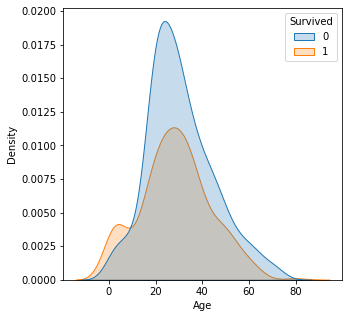

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(data=train_data,x='Age',shade=True,hue='Survived');

We notice that there is a small increase in survival for younger ages (roughly <15).

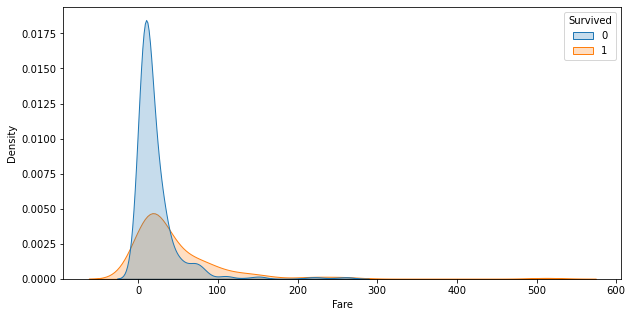

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=train_data,x='Fare',shade=True,hue='Survived');

In [6]:
min(train_data['Fare'])

0.0

The KDE plot smoothes out the distribution; there are no fares less than 0. But we can see a slightly higher chance of survival for those that paid higher fares.

Next, we look at the categorical columns. 

In [7]:
# Defining a plotting function I will use often for categorical columns. 
# It's useful to know both the rate of survival and the number of passengers 
# in each category.

def plot_categorical(dataset, column, title):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.barplot(data=dataset, x=column, y='Survived', 
                ci=None, ax=ax1,palette='tab20b').set_ylabel('Survival rate')
    
    sns.countplot(data=dataset, x=column,hue="Survived",
                  ax=ax2).set_ylabel('Counts')
    
    plt.legend(loc='upper right', title='Survived')
    plt.suptitle(title)

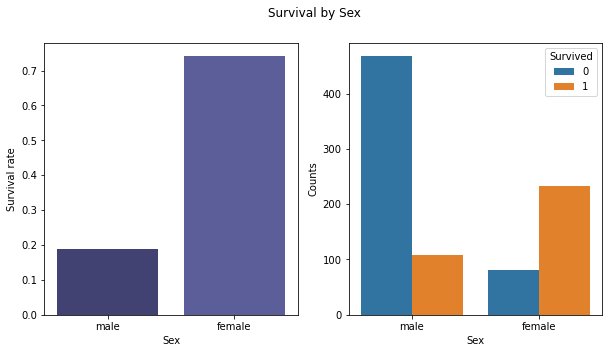

In [8]:
plot_categorical(train_data,'Sex','Survival by Sex')

We notice that female passengers have significantly higher rates of survival. We also notice that there are many more male passengers than female passengers. Since this is a strong correlation with survival, it will be necessary to keep this in mind when examining the other features. Let's first go back to the numeric categories:

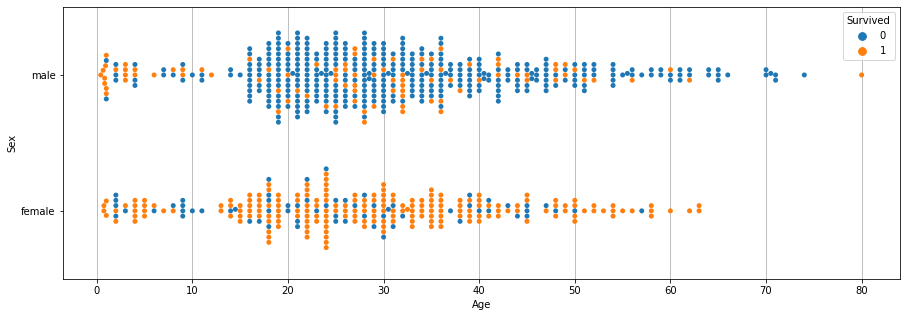

In [9]:
# A swarm plot lets us visualize all the data, distinguishing both by survival and sex.

fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)
sns.swarmplot(data=train_data,y='Sex',x='Age',hue='Survived');

As we noticed before, there is a higher rate of survival for children (with a cutoff around 12-14 yrs). Otherwise, survival appears to depend largely on sex.

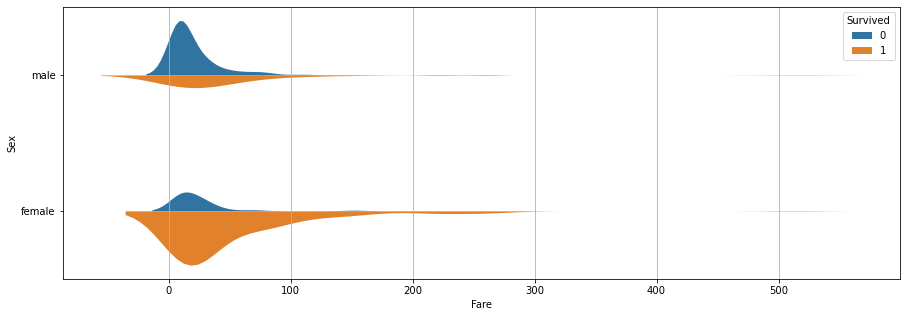

In [10]:
# The large count at lower fares makes it difficult to plot with a swarm plot, 
# so we used a violin plot instead and scaled it by count to compare the gender 
# distribution.

fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True)
sns.violinplot(
    data=train_data, x="Fare", y="Sex", hue="Survived", scale='count',
    inner=None, split=True,linewidth=0,ax=ax
);

We notice survival mostly depends on sex, and those with the very highest fares also survive. It may be useful to visualize fare categories as well.

In [11]:
def plot_quartiles(dataset, column, title, categories):
    ranges = pd.qcut(dataset[column], len(categories), labels=categories)
    plot_categorical(dataset,ranges,title)

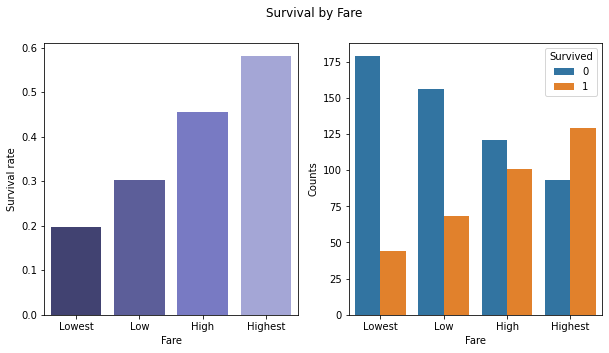

In [12]:
fare_categories = ['Lowest','Low','High','Highest']
plot_quartiles(train_data, "Fare","Survival by Fare",fare_categories)

We see a clear dependence of survival on fare, but at this point we know by now gender and whether a passenger is a child matters. Let's define a new feature designating male/female/child and visualize the data with this in mind.

In [13]:
# Designate all children as "child" regardless of gender
train_data['Passenger'] = train_data.apply(lambda x: "child" if x['Age'] < 13 else x['Sex'],axis=1)
test_data['Passenger'] = test_data.apply(lambda x: "child" if x['Age'] < 13 else x['Sex'],axis=1)

In [14]:
def plot_categorical_by_gender(dataset, column, title):
    plot_categorical(train_data,column,title)
    g = sns.catplot(x=column,hue='Survived', col = 'Passenger', data=train_data,
                kind='count', aspect=.8, ci=None)
    g.set_axis_labels(column,'Counts') 
    g.despine(right=False,top=False)

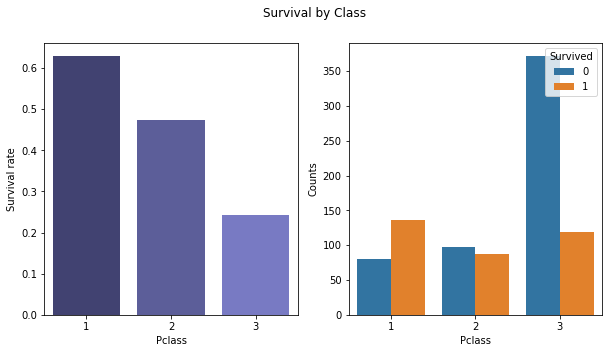

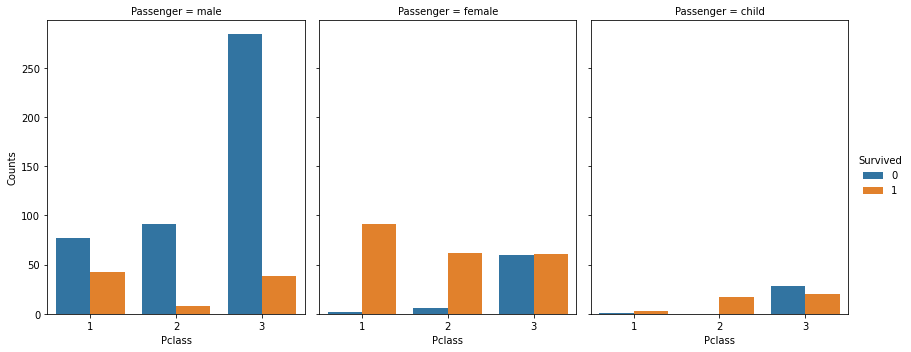

In [15]:
plot_categorical_by_gender(train_data,'Pclass','Survival by Class')

We notice that all women in 3rd class had equal chances of surviving or dying, and men in 1st class had a slightly higher than average. Across the board, passengers in third class have lower chances of surviving. 

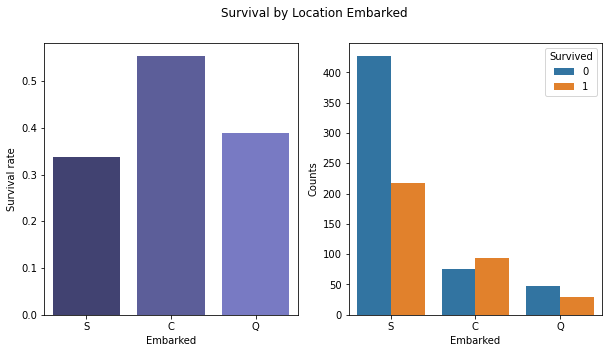

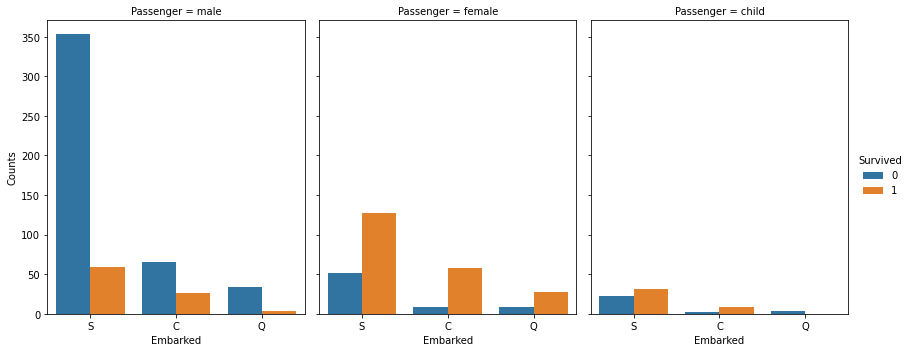

In [16]:
plot_categorical_by_gender(train_data,'Embarked','Survival by Location Embarked')

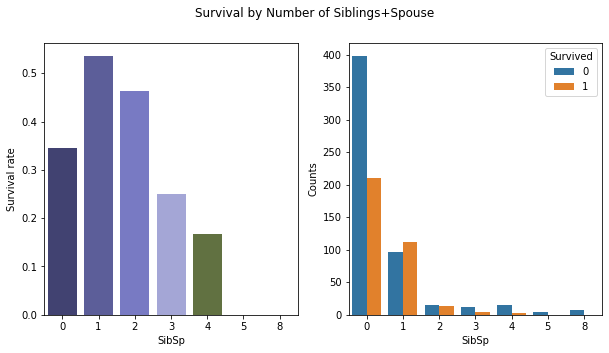

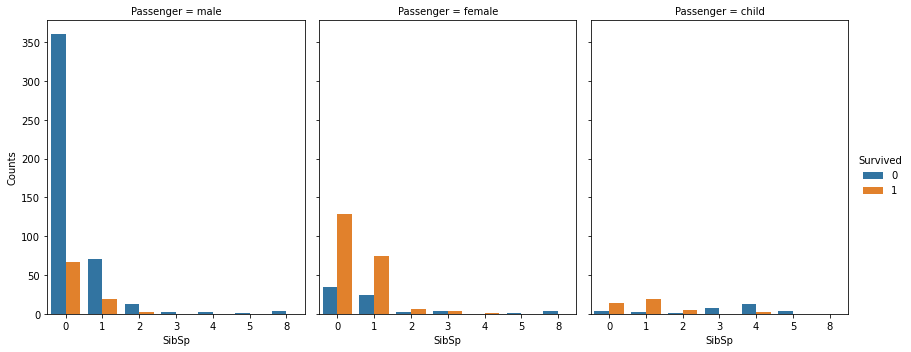

In [17]:
plot_categorical_by_gender(train_data,'SibSp','Survival by Number of Siblings+Spouse')

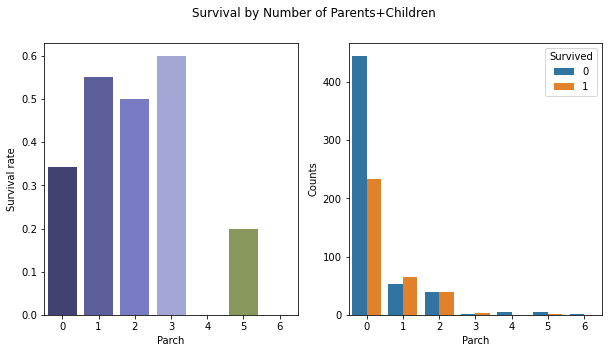

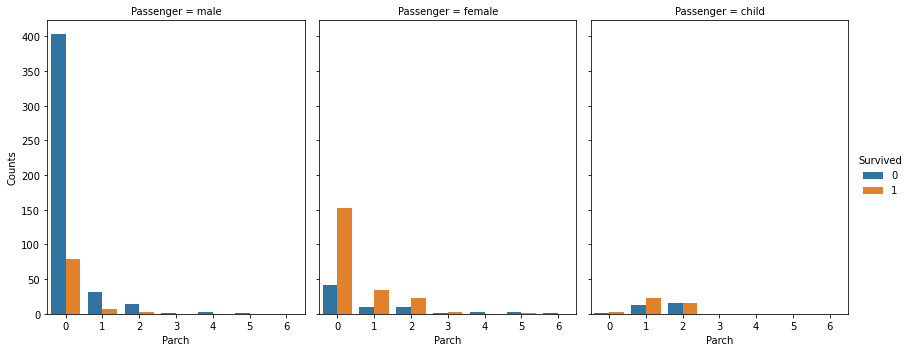

In [18]:
plot_categorical_by_gender(train_data,'Parch','Survival by Number of Parents+Children')

Everyone with larger numbers for siblings+spouse died. Similarly, more parents+children, less chance of survival.

We have not looked at `Ticket`, `Cabin`, or `Name` columns yet. To study those, we'll need some feature engineering first.

## Feature Engineering

We have already defined a new categorical feature for passenger type (male, female, child). Because of the distribution of fares, it may also be useful to define a categorical feature for fare type.

In [19]:
# Define fare categories by quartile
fare_categories = ['Lowest','Low','High','Highest']
train_data['FareRange'] = pd.qcut(train_data['Fare'], len(fare_categories), labels=fare_categories)
test_data['FareRange'] = pd.qcut(test_data['Fare'], len(fare_categories), labels=fare_categories)

We noticed that higher numbers of spouse+siblings and parents+children were associated with lower survival rates. Since these trend together, we'll define a new categorical feature for family size. 

In [20]:
# Combine 'Parch' and 'SipSp' as Family plus 1 for the passenger
train_data['Family'] = train_data['Parch']+train_data['SibSp']+1
test_data['Family'] = test_data['Parch']+test_data['SibSp']+1

# Group into family types
train_data['FamilySize'] = pd.cut(train_data.Family,[0,1,4,7,11],labels=['Solo','Small','Big','Huge'])
test_data['FamilySize'] = pd.cut(test_data.Family,[0,1,4,7,11],labels=['Solo','Small','Big','Huge'])

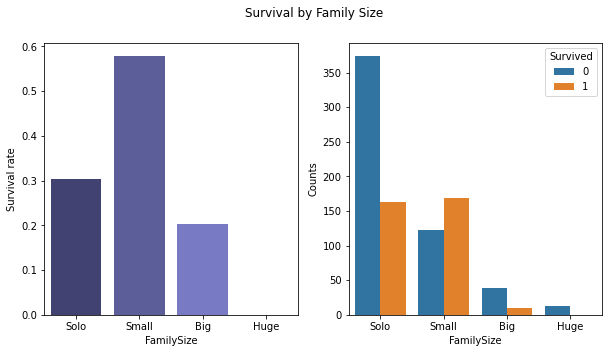

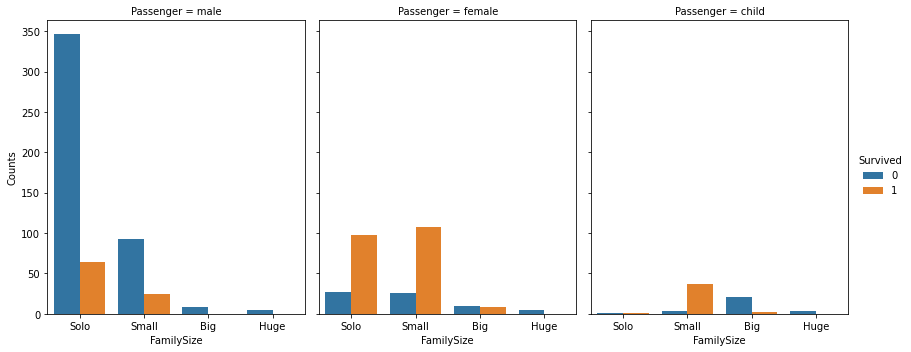

In [21]:
plot_categorical_by_gender(train_data,'FamilySize','Survival by Family Size')

Next, we will parse the name strings to extract the titles of each passenger. We then group together the less common titles.

In [22]:
train_data["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [23]:
train_data["Title"] = train_data["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data["Title"] = test_data["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())

title_filter = (lambda x: "Mrs" if (x=="the Countess" 
                                    or x=="Dona" 
                                    or x=="Mme" 
                                    or x=="Ms" 
                                    or x=="Mlle"
                                    or x=="Lady") 
                else       "Mr" if (x=="Don" 
                                    or x=="Col" 
                                    or x=="Major" 
                                    or x=="Capt" 
                                    or x=="Sir" 
                                    or x=="Jonkheer") 
                else x)

train_data["Title"] = train_data["Title"].apply(title_filter)
test_data["Title"] = test_data["Title"].apply(title_filter)

For the `Cabin` column, we will extract the first letter and save this as the section of the cabin. We will also save the number of cabins as a new feature. Note that for passengers with multiple cabins, only the section of the first cabin will be saved.

In [24]:
train_data['CabinSection'] = train_data.Cabin.apply(lambda x: x[0] if pd.notna(x) else x)
test_data['CabinSection'] = test_data.Cabin.apply(lambda x: x[0] if pd.notna(x) else x)

# Outlier category 'T' that doesn't exist in test set replaced by NaN
train_data['CabinSection'] = train_data['CabinSection'].where(train_data['CabinSection']!='T')

train_data['CabinNum'] = train_data.Cabin.apply(lambda x: x.count(" ")+1 if pd.notna(x) else x)
test_data['CabinNum'] = test_data.Cabin.apply(lambda x: x.count(" ")+1 if pd.notna(x) else x);

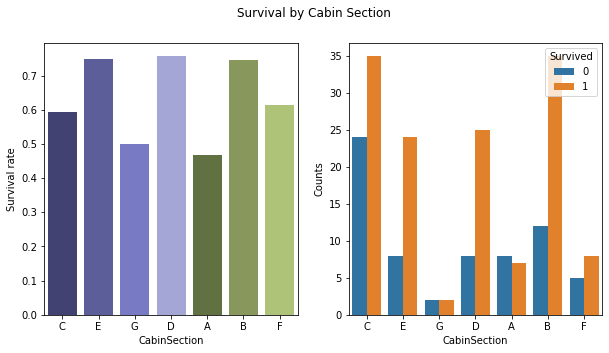

In [25]:
plot_categorical(train_data,'CabinSection','Survival by Cabin Section')

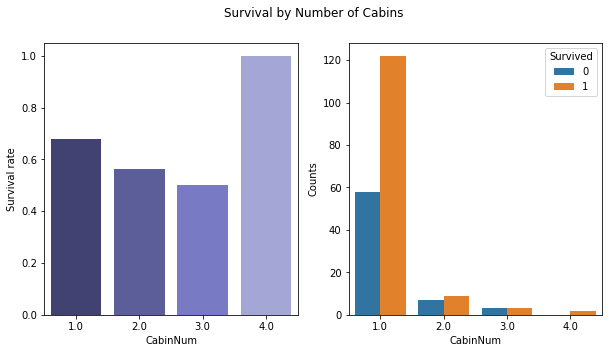

In [26]:
plot_categorical(train_data,'CabinNum','Survival by Number of Cabins')

For the `Ticket` column, we have a few choices. We could try to parse the ticket to extract different numeric and letter components, but we've chosen a simpler route of just using the first couple of characters of the string. 

In [27]:
train_data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

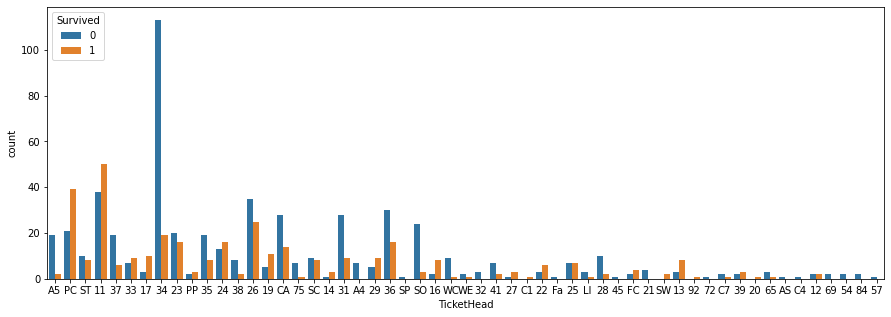

In [28]:
import re

# First removing all non-alphanumeric characters, and then saving the first two.

train_data['TicketHead'] = train_data.Ticket.astype(str).apply(lambda x: re.sub(r'\W+', '', x)[:2])
test_data['TicketHead'] = test_data.Ticket.astype(str).apply(lambda x: re.sub(r'\W+', '', x)[:2])

fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(data = train_data, x='TicketHead', hue="Survived");

We also use the length of the alphanumeric string as another feature.

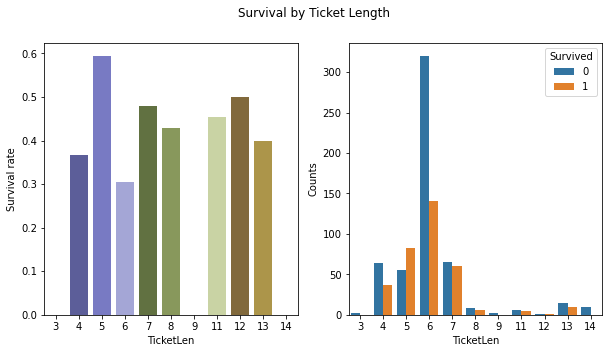

In [29]:
train_data['TicketLen'] = train_data.Ticket.astype(str).apply(lambda x: len(re.sub(r'\W+', '', x)))
test_data['TicketLen'] = test_data.Ticket.astype(str).apply(lambda x: len(re.sub(r'\W+', '', x)))

plot_categorical(train_data,'TicketLen','Survival by Ticket Length')

In [30]:
train_data.columns.to_list()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Passenger',
 'FareRange',
 'Family',
 'FamilySize',
 'Title',
 'CabinSection',
 'CabinNum',
 'TicketHead',
 'TicketLen']

## Training

Next, we set up a preprocessing and training pipeline. We will implement a voting classifier using several different models.

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score


# Feature Selection (all are categorical)

features = ["Passenger","Pclass", "FamilySize", "FareRange", "Embarked",
            "Title","CabinSection", "CabinNum","TicketLen","TicketHead"]

X = train_data[features]
X_test = test_data[features]
y = train_data["Survived"]

# Ensembling

names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Balanced Random Forest",
    "Neural Net",
    "AdaBoost",
    "XGBoost",
    "Bagging"
]

classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025, probability=True,random_state=42),
    SVC(gamma=2, C=1, probability=True,random_state=42),
    DecisionTreeClassifier(max_depth=5,random_state=42),
    RandomForestClassifier(max_depth=5,n_estimators=100,random_state=42),
    BalancedRandomForestClassifier(max_depth=5,n_estimators=100,random_state=42),
    MLPClassifier(alpha=0.1,max_iter=1000,random_state=42),
    AdaBoostClassifier(random_state=42),
    XGBClassifier(max_depth=5,random_state=42),
    BaggingClassifier(KNeighborsClassifier(5),max_samples=0.5,max_features=0.5,random_state=42)
]

# Using a voting classifier to chose the best predictions from all of the above classifiers
eclf = VotingClassifier(estimators=tuple(zip(names,classifiers)),voting='soft')

# Pipeline includes an imputer to handle missing data, one-hot encoder, and ensemble classifier
pipeline = make_pipeline(SimpleImputer(strategy='most_frequent',add_indicator=True),
                         OneHotEncoder(handle_unknown='ignore'),
                         eclf)

# Train the model
pipeline.fit(X,y)

# 25-fold cross-validation 
print('Cross-validation accuracy: {:.3f}'.format(cross_val_score(pipeline,X,y,scoring='accuracy',cv=25).mean()))

Cross-validation accuracy: 0.835


## Predictions

In [33]:
predictions = pipeline.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Successfully saved!")

Successfully saved!
